In [ ]:
!pip install --quiet transformers seaborn datasets evaluate rouge_score nltk numpy spacy lexrank

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.3 MB/s eta 0:00

In [ ]:
!pip install --quiet --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 6.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/RuSportSum/train_after_match_pairs_data4.csv" /content/train.csv
!cp "/content/drive/MyDrive/RuSportSum/eval_after_match_pairs_data4.csv" /content/eval.csv
!cp "/content/drive/MyDrive/RuSportSum/test_after_match_pairs_data4.csv" /content/test.csv
!cp "/content/drive/MyDrive/RuSportSum/summ_after_match.csv" /content/summ_after_match.csv

In [ ]:
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from lexrank import LexRank
from spacy.lang.ru.stop_words import STOP_WORDS

import nltk
from nltk.tokenize import sent_tokenize
import numpy as np
from datasets import Dataset
from datasets import load_dataset, load_metric
from sklearn.model_selection import train_test_split
import transformers
from transformers import (
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    HfArgumentParser,
    MBart50TokenizerFast,
    MBartTokenizer,
    MBartTokenizerFast,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    set_seed,
)
import evaluate

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
train = pd.read_csv('/content/train.csv')
eval = pd.read_csv('/content/eval.csv')
test = pd.read_csv('/content/test.csv')

summ_after_match = pd.read_csv('/content/summ_after_match.csv')

train

,match_id,news_id,name,team1,team2,relevant_part,type,minute,content,news_name_body
0,965329,1029966958,Германия. Бундеслига,Бавария,Майнц,0,empty,0,"0 минута. Привет всем, кому небезразличен неме...",«Бавария» – «Майнц» – 2:0. Швайнштайгер постав...
1,965329,1029966958,Германия. Бундеслига,Бавария,Майнц,0,empty,0,0 минута.,«Бавария» – «Майнц» – 2:0. Швайнштайгер постав...
2,965329,1029966958,Германия. Бундеслига,Бавария,Майнц,0,empty,0,0 минута. Досрочно завоевав серебряную салатни...,«Бавария» – «Майнц» – 2:0. Швайнштайгер постав...
3,965329,1029966958,Германия. Бундеслига,Бавария,Майнц,0,empty,0,0 минута. В последних пяти очных встречах «Бав...,«Бавария» – «Майнц» – 2:0. Швайнштайгер постав...
4,965329,1029966958,Германия. Бундеслига,Бавария,Майнц,0,empty,0,"0 минута. За вычетом травм состав у ""Баварии"" ...",«Бавария» – «Майнц» – 2:0. Швайнштайгер постав...
...,...,...,...,...,...,...,...,...,...,...
658316,480946,146875038,Англия. Премьер-лига,Ливерпуль,Суонси,0,empty,90,"90 минута. И все. ""Ливерпуль"" громит анабиозны...",«Ливерпуль» – «Суонси» – 5:0. Старридж постави...
658317,480946,146875038,Англия. Премьер-лига,Ливерпуль,Суонси,0,empty,90,"90 минута. ""Суонси"" попробовал свой резерв, и ...",«Ливерпуль» – «Суонси» – 5:0. Старридж постави...
658318,480946,146875038,Англия. Премьер-лига,Ливерпуль,Суонси,0,empty,90,90 минута. Теперь по крайней мере на восьмую с...,«Ливерпуль» – «Суонси» – 5:0. Старридж постави...
658319,480946,146875038,Англия. Премьер-лига,Ливерпуль,Суонси,0,empty,90,"90 минута. На этом все. Спасибо за внимание, в...",«Ливерпуль» – «Суонси» – 5:0. Старридж постави...


In [ ]:
def concatenate_content(messages):
  return ' '.join([str(message).strip() for message in messages])

summ_after_match = summ_after_match[summ_after_match['relevant_part'] == 1]
summ_after_match.drop(['relevant_part', 'type'], axis=1, inplace=True)


grouping_columns = ['match_id', 'news_id', 'name', 'team1', 'team2', 'news_name_body']
summ_after_match = summ_after_match.sort_values(['match_id', 'news_id', 'minute'], ascending = True).groupby(grouping_columns)['content'].apply(concatenate_content).reset_index()
summ_after_match

,match_id,news_id,name,team1,team2,news_name_body,content
0,18996,25421056,Россия. Премьер-лига,Рубин,Ахмат,Колобаев отсудил 100-й матч в премьер-лиге & И...,90 минута. Все! Колобаев прекращает матч де-юр...
1,19003,25255675,Россия. Премьер-лига,Химки,Крылья Советов,«Крылья Советов» прервали безвыигрышную серию ...,0 минута. Sports.ru предлагает Вашему вниманию...
2,19020,31530734,Россия. Премьер-лига,ЦСКА,Крылья Советов,Гильерме сделал дубль в дебютном матче за ЦСКА...,60 минута. А это 2:0! Привет от Гильерме! Зама...
3,19029,33302111,Россия. Премьер-лига,Сатурн,Спартак,Лоськов провел 400-й матч в чемпионатах России...,0 минута. Всем привет. Все флаги и баннеры в г...
4,19042,35218066,Россия. Премьер-лига,Ахмат,Локомотив,Бракамонте дебютировал в составе «Терека» & На...,"53 минута. 2:0! Вип-ложа ликует, Вячеслав Гроз..."
...,...,...,...,...,...,...,...
8239,1104865,1040574809,Кубок Стэнли,Питтсбург,Сан-Хосе,«Питтсбург» – «Сан-Хосе». Раст может пропустит...,"60 минута. 3:2 - ""Питтсбург"" вырывает победу в..."
8240,1104866,1040621229,Кубок Стэнли,Питтсбург,Сан-Хосе,НХЛ. Кубок Стэнли. Финал. «Питтсбург» вновь по...,63 минута. гол!!! Шери - 2:1! 4-й гол в плей-о...
8241,1104866,1040636713,Кубок Стэнли,Питтсбург,Сан-Хосе,НХЛ. Форвард «Питтсбурга» Шери забил первый по...,63 минута. гол!!! Шери - 2:1! 4-й гол в плей-о...
8242,1104866,1040636981,Кубок Стэнли,Питтсбург,Сан-Хосе,НХЛ. Мюррей одержал 13-ю победу в дебютном пле...,63 минута. гол!!! Шери - 2:1! 4-й гол в плей-о...


In [ ]:
train = summ_after_match.merge(train[['match_id', 'news_id']].drop_duplicates(), how='inner', left_on=['match_id', 'news_id'], right_on=['match_id', 'news_id'])
eval = summ_after_match.merge(eval[['match_id', 'news_id']].drop_duplicates(), how='inner', left_on=['match_id', 'news_id'], right_on=['match_id', 'news_id'])
test2 = summ_after_match.merge(test[['match_id', 'news_id']].drop_duplicates(), how='inner', left_on=['match_id', 'news_id'], right_on=['match_id', 'news_id'])

In [ ]:
data = pd.concat([train, eval, test])
data['len_content'] = data['content'].apply(lambda x: len(str(x).split()))
data['len_news_name_body'] = data['news_name_body'].apply(lambda x: len(str(x).split()))
data[['len_content', 'len_news_name_body']].describe()

,len_content,len_news_name_body
count,8244.000000,8244.000000
mean,123.920548,59.366934
std,120.038740,25.920691
min,3.000000,8.000000
25%,58.000000,40.000000
50%,99.000000,54.000000
75%,154.000000,73.000000
max,1903.000000,401.000000


<Axes: xlabel='len_news_name_body'>

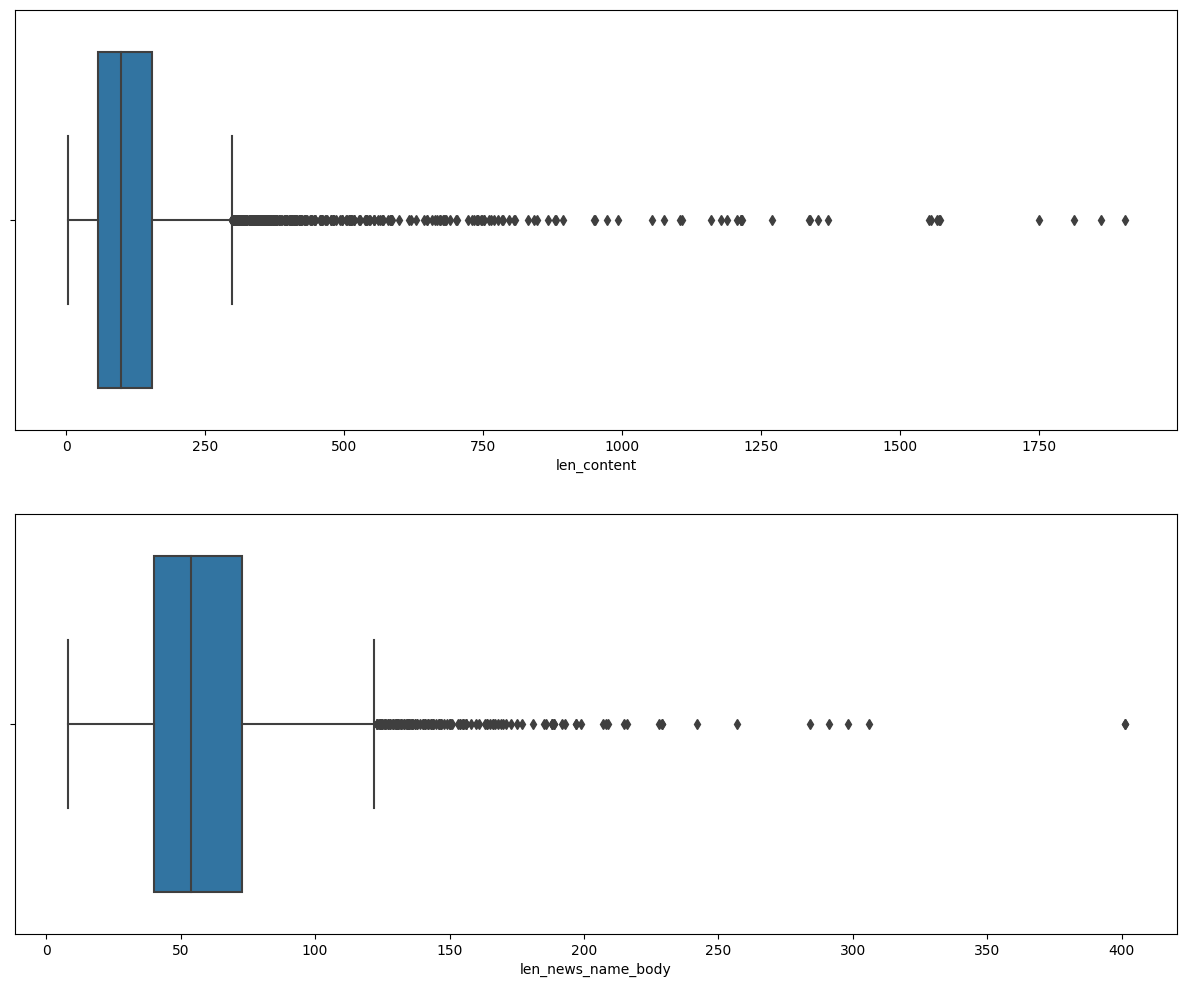

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

sns.boxplot(ax=axes[0], x='len_content', data=data)
sns.boxplot(ax=axes[1], x='len_news_name_body', data=data)

In [ ]:
train.to_csv('train.csv', index=False, encoding='utf-8')
eval.to_csv('eval.csv', index=False, encoding='utf-8')
test.to_csv('test.csv', index=False, encoding='utf-8')

### Обобщающие новости

#### Fine-tuning модели mbart-large-cc25

In [ ]:
SEED = 3
lang = 'ru_RU'
set_seed(SEED)

In [ ]:
dataset = load_dataset("csv", data_files={'train': 'train.csv', 'eval': 'eval.csv', 'test': 'test.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4e98dfbcbbdd813e/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset['train'][0]

{'match_id': 18996,
 'news_id': 25421056,
 'name': 'Россия. Премьер-лига',
 'team1': 'Рубин',
 'team2': 'Ахмат',
 'news_name_body': 'Колобаев отсудил 100-й матч в премьер-лиге & Игра 18-го тура премьер-лиги «Рубин» – «Терек» (4:0) стала для арбитра Александра Колобаева 100-й в высшем дивизионе. Рефери, который начал работать в элитной лиге с октября 2000 года, стал 20-м российским судьей, который достиг отметки в 100 матчей. По количеству проведенных встреч среди действующих арбитров Колобаева опережают лишь 5 человек: Николай Иванов, Юрий Баскаков, Станислав Сухина, Александр Гвардис и Игорь Егоров, сообщает «Спорт-Экспресс» .',
 'content': '90 минута. Все! Колобаев прекращает матч де-юре, де-факто окончившийся уже на 20-й минуте!'}

In [ ]:
model_name = "facebook/mbart-large-cc25"

config = transformers.AutoConfig.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, config=config)

In [ ]:
model.config.decoder_start_token_id = tokenizer.convert_tokens_to_ids(lang)

In [ ]:
tokenizer.src_lang = lang
tokenizer.tgt_lang = lang

# Для mbart нужен токен языка
forced_bos_token_id = (tokenizer.lang_code_to_id[lang])

model.config.forced_bos_token_id = forced_bos_token_id

In [ ]:
text_column = 'content'
summary_column = 'news_name_body'

In [ ]:
max_source_length = 512
max_target_length = 300
padding = 'max_length'
ignore_pad_token_for_loss = True

In [ ]:
def preprocess_function(examples):
  inputs, targets = [], []

  for i in range(len(examples[text_column])):
      if examples['name'][i] and examples['team1'][i] and examples['team2'][i] and examples[text_column][i] and examples[summary_column][i]:
          inputs.append('</s>'.join([examples['name'][i], examples['team1'][i], examples['team2'][i], examples[text_column][i]]))
          targets.append(examples[summary_column][i])

  model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

  labels = tokenizer(text_target=targets, max_length=max_target_length, padding=padding, truncation=True)

  # Для игнорирования паддинга в loss
  if padding == "max_length" and ignore_pad_token_for_loss:
      labels["input_ids"] = [
          [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
      ]

  model_inputs["labels"] = labels["input_ids"]

  return model_inputs

In [ ]:
train_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=['match_id', 'news_id', 'name', 'team1', 'team2', 'content',  'news_name_body'],
    )

Map (num_proc=2):   0%|          | 0/7156 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/947 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/141 [00:00<?, ? examples/s]

In [ ]:
# Data collator
label_pad_token_id = -100
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

In [ ]:
# Метрика
metric = evaluate.load("rouge")

In [ ]:
def postprocess_text(preds, labels):
  preds = [pred.strip() for pred in preds]
  labels = [label.strip() for label in labels]

  # rougeLSum ожидает новую строку после каждого предложения
  preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
  labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

  return preds, labels

In [ ]:
def compute_metrics(eval_preds):
  preds, labels = eval_preds
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  if ignore_pad_token_for_loss:
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

  result = metric.compute(predictions=decoded_preds, references=decoded_labels, tokenizer=lambda x: x.split())
  result = {k: round(v * 100, 4) for k, v in result.items()}
  prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
  result["gen_len"] = np.mean(prediction_lens)
  return result

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir=".",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=16,
    gradient_checkpointing=True,
    optim="adafactor",
    logging_steps=100,
    evaluation_strategy='epoch',
    save_strategy="epoch",
    load_best_model_at_end=True,
    predict_with_generate=True
    )

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset['train'],
    eval_dataset=train_dataset['eval'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
    )

train_result = trainer.train()

You're using a MBartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,1.790000,1.272623,35.787900,18.594100,31.487300,34.322400,91.724393
1,1.286000,1.161121,36.070900,19.164200,31.700600,34.533900,96.918691
2,1.163800,1.129942,37.056600,19.960000,32.286900,35.370500,99.687434


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


In [ ]:
trainer.save_model('/content/drive/MyDrive/RuSportSum/save_model')

#### Оценка качества настроенного mBART на тестовом наборе данных

In [ ]:
predict_results = trainer.predict(
    train_dataset['test'],
    metric_key_prefix="predict",
    max_length=max_target_length,
    num_beams=3
)
metrics = predict_results.metrics

In [ ]:
metrics

{'predict_loss': 1.254770278930664,
 'predict_rouge1': 34.2733,
 'predict_rouge2': 17.8649,
 'predict_rougeL': 29.8442,
 'predict_rougeLsum': 32.4849,
 'predict_gen_len': 99.49645390070921,
 'predict_runtime': 159.0989,
 'predict_samples_per_second': 0.886,
 'predict_steps_per_second': 0.226}

In [ ]:
predictions = []
if trainer.is_world_process_zero():
  if training_args.predict_with_generate:
    predictions = tokenizer.batch_decode(
        predict_results.predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    predictions = [pred.strip() for pred in predictions]

In [ ]:
output_prediction_file = "generated_predictions.txt"
with open(output_prediction_file, "w", encoding='utf-8') as writer:
  writer.write("\n".join(predictions).encode('utf-8').decode("utf-8"))

In [ ]:
print('часть матча: ', dataset['test'][0]['content'])
print('оригинальная новость: ', dataset['test'][0]['news_name_body'])
print('предсказанная новость: ', predictions[0])

часть матча:  0 минута. Всем привет. Прекрасная погода в Химках. С удовольствием вышел бы на поле прямо сейчас. Но вместо нас с вами это будут делать футболисты "Динамо" и нальчикского "Спартака". 22-й тур. 90 минута. ВСЕ. 0:3.
оригинальная новость:  Во время игры «Динамо» – Нальчик произошла потасовка между динамовскими фанатами и службой безопасности & На матче 26-го тура премьер-лиги «Динамо» «Спартак» Нальчик (0:3) на трибуне D «Арены Химки» в середине второго тайма произошла потасовка между динамовскими фанатами и службой безопасности стадиона, в количестве 15 человек скопившейся в эпицентре конфликта. Инцидент произошел во время выхода на замену Александра Кокорина, когда счет был 2:0 в пользу гостей, сообщает корреспондент Sports.ru Алексей Фомин. Посмотреть текстовую трансляцию игры можно здесь .
предсказанная новость:  «Динамо» – «Спартак» Нальчик – 0:3. Команды голов не забили & Сегодня в 22-м туре чемпионата России в Химках на «Арене Химки» московское «Динамо» уступило нальч

In [ ]:
print('часть матча: ', dataset['test'][1]['content'])
print('оригинальная новость: ', dataset['test'][1]['news_name_body'])
print('предсказанная новость: ', predictions[1])

часть матча:  0 минута. Эпохальный матч грядет, тревожно побрякивая остроконечностью звезд, надвигающихся друг на друга. Это случится раньше, чем хотели многие. Это должно было произойти потом, в самом конце. Но зато теперь это произойдет совершенно точно и неотвратимо поглотит нас своей энергией лучшего хоккея на планете: КАНАДА - РОССИЯ! 60 минута. Все! Сколько там, 3:7? Получается, мы не проходим... 60 минута. 28:42 по броскам, штрафных минут по 10. Прекрасно сыграли канадцы, образцово. Сумасшедший темп задали с самого начала, и наши не выдержали. Очень жаль, конечно, но Канада заслужила эту победу своим потрясающим настроем и выдающимся хоккеем.
оригинальная новость:  Сборная России уступила Канаде на Олимпиаде впервые за последние 50 лет & Сборная России, уступившая в матче 1/4 финала Канаде (3:7), проиграла первую встречу «кленовым листьям» на Олимпийских играх за последние 50 лет. Напомним, что Россия не проигрывала Канаде на Олимпийских играх с 1960 года, когда на Играх в Скво-

In [ ]:
print('часть матча: ', dataset['test'][2]['content'])
print('оригинальная новость: ', dataset['test'][2]['news_name_body'])
print('предсказанная новость: ', predictions[2])

часть матча:  37 минута. гол!! Не страшно немцам забивать СЕЙЧАС?! гол-красавец! При атаке три в одного Барта вспомнил Дацюка и бросил сам! Вратарь спас, но Барта подобрал отскок и, словно воспитанник МХАТа, уложил на лед защитника с Густавссоном и поразил ворота "Тре крунур"! 1:1! 44 минута. гол! Шведы забили! 2:1! Андерссон! Проскользнул по борту в зону, дал по тормозам и метнул с острого угла! Эндрас пустил шайбу между щитков. 60 минута. И финальная сирена! Шведы с бронзой!
оригинальная новость:  Сборная Швеции выиграла бронзу ЧМ-2010 & Сборная Швеции, победив в матче за 3-е место Германию (3:1), выиграла бронзовые медали ЧМ-2010. Команда Уве Круппа добилась лучшего результата за долгие годы, финишировав четвертой. «Тре крунур» повторили прошлогодний результат: на чемпионате мира в Берне они также были третьими. Тогда, в матче за бронзу, были переиграны американцы (4:2). Всего шведы 16 раз на первенствах мира занимали третье место, 18 раз – второе и 8 раз – первое, информирует Afton